##  Auto-encoder.

#### Librerías necesarias

In [77]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from PIL import Image


#### Preprocessing

In [80]:
df = pd.read_csv('product_preprocessed.csv')
def extract_filename(path):
    return path.split('/')[-1]

# Apply the function to the 'des_filename' column
df['des_filename'] = df['des_filename'].apply(extract_filename)


In [82]:
# Define a function to load images from a folder, excluding names in the provided list
def load_images_from_folder(folder, size=(56, 56)):
    images = []
    for filename in os.listdir(folder):
        # Check if the filename contains any excluded substring
        if filename not in df['des_filename'].values:
            continue  # Skip this file
        img_path = os.path.join(folder, filename)
        try:
            # Open the image file
            with Image.open(img_path) as img:
                # Resize image to match model input
                img = img.resize(size)
                # Convert image to grayscale
                img = img.convert('L')
                # Convert image to numpy array and normalize
                img_array = np.array(img) / 255.0
                # Add a channel dimension ([56, 56] -> [56, 56, 1])
                img_array = np.expand_dims(img_array, axis=-1)
                images.append(img_array)
        except IOError as e:
            # If the file is not an image, ignore it
            print(f"Error opening {img_path}: {e}")
    return np.array(images)



# Use the function with the loaded excluded substrings
folder_path = 'images'
images = load_images_from_folder(folder_path)

# Function to calculate similarity between two encoded images
def calculate_similarity(encoded_img1, encoded_img2):
    # Flatten the compressed representations
    encoded_img1 = encoded_img1.flatten()
    encoded_img2 = encoded_img2.flatten()
    
    # Calculate the similarity (e.g., using cosine similarity)
    similarity = cosine_similarity(encoded_img1.reshape(1, -1), encoded_img2.reshape(1, -1))
    return similarity

In [84]:
# Split the images data into training and validation sets
x_train, x_val = train_test_split(images, test_size=0.1, random_state=42)

#### Modelo

In [85]:
# Define the encoder
input_img = layers.Input(shape=(56, 56, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Define the decoder
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Initialize early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


In [86]:
# Train the model with early stopping
autoencoder.fit(x_train, x_train,
                epochs=50,  # You might want to change the number of epochs
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[early_stopping])  # Add early stopping here

# Encoder model to create compressed representations
encoder = models.Model(input_img, encoded)

# Use the trained encoder to compress images
encoded_images = encoder.predict(images)

# Visualize the original and reconstructed images
decoded_images = autoencoder.predict(images)

Epoch 1/50
32/32 [==============================] - 35s 1s/step - loss: 0.5665 - val_loss: 0.4417
Epoch 2/50
32/32 [==============================] - 32s 1s/step - loss: 0.4158 - val_loss: 0.3834
Epoch 3/50
32/32 [==============================] - 32s 1s/step - loss: 0.3673 - val_loss: 0.3538
Epoch 4/50
32/32 [==============================] - 32s 1s/step - loss: 0.3495 - val_loss: 0.3452
Epoch 5/50
32/32 [==============================] - 32s 997ms/step - loss: 0.3442 - val_loss: 0.3419
Epoch 6/50
32/32 [==============================] - 32s 1s/step - loss: 0.3411 - val_loss: 0.3394
Epoch 7/50
32/32 [==============================] - 32s 1s/step - loss: 0.3388 - val_loss: 0.3378
Epoch 8/50
32/32 [==============================] - 32s 1s/step - loss: 0.3373 - val_loss: 0.3360
Epoch 9/50
32/32 [==============================] - 32s 1s/step - loss: 0.3359 - val_loss: 0.3351
Epoch 10/50
32/32 [==============================] - 32s 1s/step - loss: 0.3353 - val_loss: 0.3343
Epoch 11/50
32/3

In [87]:
# Save the encoded images to a binary file in NumPy format
np.save('encoded_images.npy', encoded_images)


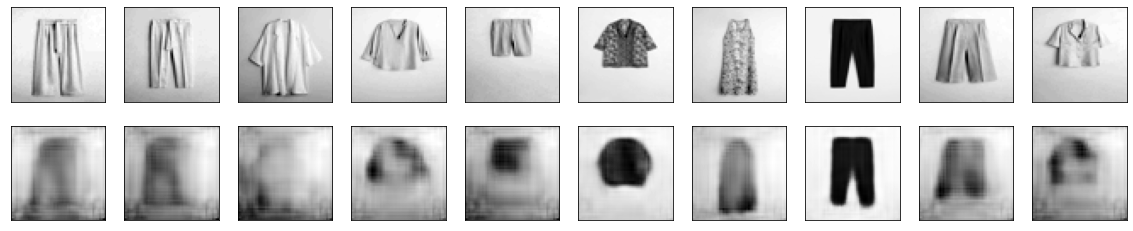

In [ ]:
n = min(10, len(images))  # How many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(56, 56))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Model preentrenat de google (no usat finalment):

In [41]:
import torch
from transformers import ViTFeatureExtractor, ViTModel
from torch.nn.functional import normalize
from PIL import Image
import os

# Load the feature extractor and model from Hugging Face
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Your images folder path
images_folder = "./images"

# List all the image files in the images folder
image_files = [file for file in os.listdir(images_folder) if file.endswith(('png', 'jpg', 'jpeg'))]

# Initialize the similarity matrix
n = len(image_files)
similarity_matrix = torch.zeros((n, n))

# Dictionary to hold image embeddings
image_embeddings = {}



In [63]:
# Convertimos las claves del diccionario en una lista y encontramos el índice
posicion = list(image_embeddings.keys()).index('2019_53091158_OR.jpg')

print(f"La posición numérica de la clave es: {posicion}")

La posición numérica de la clave es: 0


In [62]:
# Convertimos las claves del diccionario en una lista y encontramos el índice
posicion = list(image_embeddings.keys()).index('2019_53080809_OR.jpg')

print(f"La posición numérica de la clave es: {posicion}")

La posición numérica de la clave es: 2685


In [42]:
# Extract features for each image and store in a dictionary
for i, image_file in enumerate(image_files):
    # Load image
    image_path = os.path.join(images_folder, image_file)
    image = Image.open(image_path).convert('RGB')
    
    # Prepare image
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Extract features
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Only take the embeddings from the last layer and normalize
    embeddings = normalize(outputs.last_hidden_state[:,0,:], dim=1)
    
    # Store embeddings in the dictionary
    image_embeddings[image_file] = embeddings
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [50]:
# Convert to a numpy array
numpy_dict = {k: v.numpy() for k, v in image_embeddings.items()}

# Save to .npy file
np.save('google_embedings.npy', numpy_dict)